<center><h1 style="font-size:40px;">Project 3<br>Object detection</h1></center>

---

This project will develop an object detection system with **Single-shot multibox detectors (SSD)**. The task is to use the COCO dataset from *https://cocodataset.org* to predict bounding boxes.  

All **tasks** include **TODO's** thare are expected to be done before the deadline. The highlighted **Question's** should be answered in the report. Keep the answers separated so it is easy to read for the grading. Some sections include asserts or an expected result to give a and expected results are given. Some sections does not contain any **TODO's** but is good to understand them. 

For the **report** we have prepared an *Report.ipynb* notebook. The report should act as a summary of your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include all **parts** in the report!

This lab logs metrics to **Tensorboard**, for instructions to install check the introduction pdf.

Good luck!

---

# Task

**TODO:** Implement **SSD** to predict bounding boxes on the training set.

**TODO:** Select a good metric to evaluate the models performance and argue why the metric give a good overview of the performance.

**TODO:** Is it possible to reduce the number of bounding boxes? If yes, implement it and why it is a good solution.


**Question:** Explain in the report what you did and why. Present a pipeline of the code. 

# Import packages

In [3]:
%load_ext autoreload
%autoreload 2
# Hacky solution to ac>cess the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('../..')))

In [9]:
from config import LabConfig
import torchmetrics
import transforms as T
import torch

from DL_labs.utils.dataset import CocoDataset
from DL_labs.utils.plot import Detection

## Load config
Note that this lab does not support for fineGrained dataset.

In [5]:
cfg = LabConfig()
cfg.todict()

{'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'fineGrained': False,
 'NUM_CLASSES': 4,
 'COCO_DATASET': '/var/metrics/DL_DATASET/coco',
 'training_img_dir': '/var/metrics/DL_DATASET/coco/train2017',
 'validation_img_dir': '/var/metrics/DL_DATASET/coco/validation2017',
 'training_annotations': '/var/metrics/DL_DATASET/coco/annotations/instances_train2017.json',
 'testing_img_dir': '../data/FlyingObjectDataset_10K/testing',
 'spiral_path': '../data/lab2/spiral.dat',
 'SEED': 420,
 'GPU': -1,
 'IMAGE_WIDTH': 128,
 'IMAGE_HEIGHT': 128,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'BATCH_SIZE': 32,
 'SAVE_EVERY': 1,
 'TENSORBORD_DIR': 'logs/'}

# Dataset
Coco contain a wide variety of images and the corresponding annotation. To download the dataset we use aria2 and the script found in *download.sh*. Note that the dataset is quite large so we need plenty of space on the hard drive.

Change code below to True if you want to download the data. Dont forget to change back since it will download the data each time you run the full notebook.

In [6]:
if False:
    !sh ./download.sh $cfg.COCO_DATASET

## Augmentation
To ensure that each image have the same shape we pad the dataset. It is possible to resize the images but then the bounding boxes also have to be transformed to correct shape which is not covered in this project! 

In [7]:
train_transform = T.Compose([
    T.ToTensor(),
    T.SquarePad(480, 640)
])
test_transform = T.Compose([
    T.ToTensor(),
    T.SquarePad(480, 640)
])

## Dataloader

In [16]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(
    CocoDataset(
        root=cfg.training_img_dir,
        annotation=cfg.training_annotations,
        transforms=train_transform
    ),
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    collate_fn=collate_fn)

validation_dataloader = torch.utils.data.DataLoader(
    CocoDataset(
        root=cfg.validation_img_dir,
        annotation=cfg.validation_annotations,
        transforms=train_transform
    ),
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    collate_fn=collate_fn)

loading annotations into memory...
Done (t=9.83s)
creating index...
index created!


## Visualisations

Print the following to get an idea of the different categories

In [19]:
cats = train_dataloader.dataset.coco.loadCats(coco_dataset.coco.getCatIds())
", ".join([cat['name'] for cat in cats])

'person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush'

To get an idea of what bounding boxes are we can plot a subset of the dataset. Each color represent a class which we can access through the variable *t_y*. We use colors to get an idea of different objects in order to separate them from each other.

In [20]:
t_x, t_y = next(iter(train_dataloader))

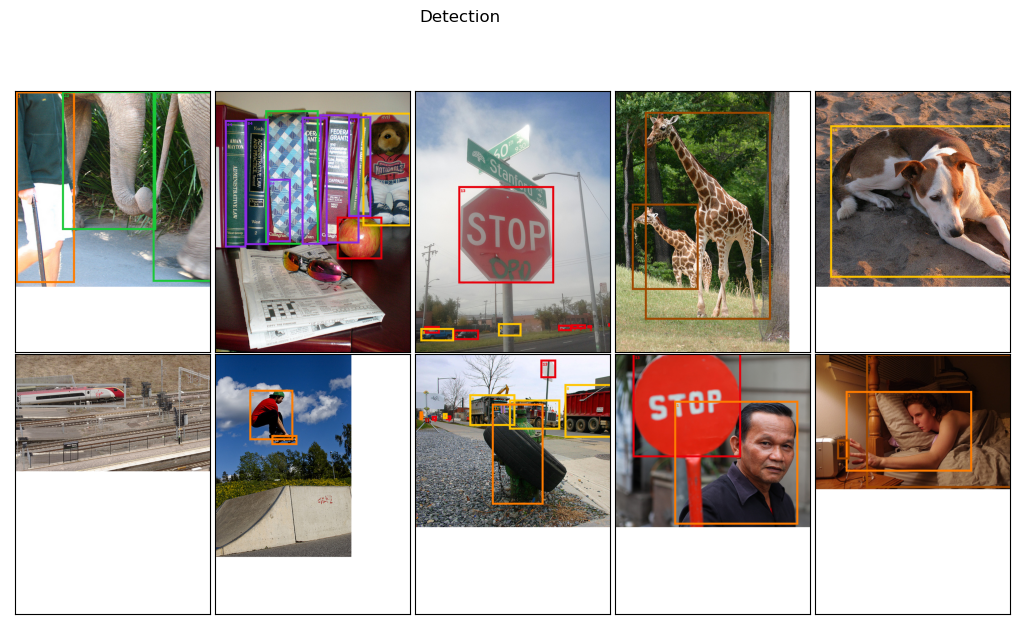

In [23]:
Detection.data(t_x, t_y, max(coco_dataset.coco.cats.keys()), plot_kwargs={'nimages':10}, width=5, font_size=30)

# Implementation

---